# Konnektor - Building Ligand Networks

this is Konnektor, which you can use to construct different types of Networks.

In [ ]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab
    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/konnektor/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml
    
    from google.colab import output
    output.enable_custom_widget_manager()

In [13]:
import sys

import numpy as np
from rdkit import Chem

try:
    from kartograf import KartografAtomMapper, MappingRMSDScorer
except ModuleNotFoundError:
    !{sys.executable} -m pip install git+https://github.com/OpenFreeEnergy/kartograf.git
    from kartograf import KartografAtomMapper, MappingRMSDScorer


import logging
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Cloning https://github.com/OpenFreeEnergy/kartograf.git to /tmp/pip-req-build-3wfnqnpv
  Running command git clone --filter=blob:none --quiet https://github.com/OpenFreeEnergy/kartograf.git /tmp/pip-req-build-3wfnqnpv
  Resolved https://github.com/OpenFreeEnergy/kartograf.git to commit f371334de341895d98bfac7c9b32227750237645
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


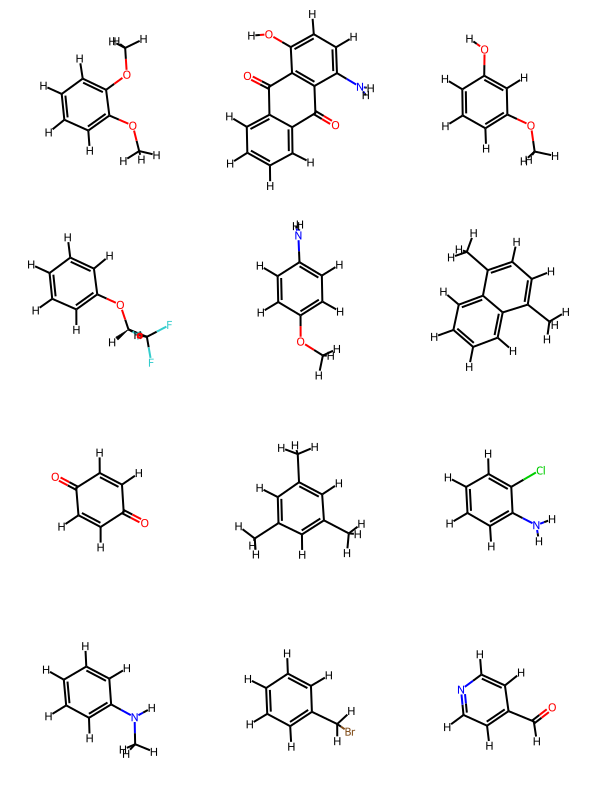

In [16]:
from kartograf import SmallMoleculeComponent
from konnektor.visualization import draw_ligand_network, draw_network_widget
from konnektor.data import benzenes_sdf_path

mapper = KartografAtomMapper()
scorer = MappingRMSDScorer()

rdmols = list(Chem.SDMolSupplier(benzenes_sdf_path, removeHs=False))
compounds = [SmallMoleculeComponent.from_rdkit(m) for m in rdmols]
compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"], compounds))
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

# Radial Network Layout

In [18]:
from konnektor.network_planners import StarLigandNetworkPlanner
ligand_network_planner = StarLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)

In [19]:
radial_network = ligand_network_planner(compounds)
radial_network.name="Star Network"
radial_network

<LigandNetwork-0b6cb8b74e68d21a9219b71a08f6560b>

In [ ]:
draw_network_widget(radial_network);

interactive(children=(Dropdown(description='layout', index=2, options=('dagre', 'breadthfirst', 'concentric', …

CytoscapeWidget(cytoscape_layout={'name': 'concentric', 'nodeSpacing': 50, 'edgeLengthVal': 50}, cytoscape_sty…

## Starry Sky Network Layout

In [21]:
from konnektor.network_planners import StarrySkyLigandNetworkPlanner
ligand_network_planner = StarrySkyLigandNetworkPlanner(mapper=KartografAtomMapper(), 
                                                       scorer=scorer, 
                                                       target_node_connectivity=3)

In [22]:
starry_sky_network = ligand_network_planner(compounds)
starry_sky_network.name="Starry Sky Network"
starry_sky_network

<LigandNetwork-13485b4ea7b9d868817312f03a80bc01>

In [ ]:
draw_network_widget(starry_sky_network);

interactive(children=(Dropdown(description='layout', index=2, options=('dagre', 'breadthfirst', 'concentric', …

# Minimal Spanning Tree

In [26]:
from konnektor.network_planners import MinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)


In [27]:
mst_network = ligand_network_planner(compounds)
mst_network.name="Min Spanning Tree Network"
mst_network

<LigandNetwork-09da220103f274585d20ac1b6a4f5b32>

In [ ]:
draw_network_widget(mst_network, layout="dagre");

interactive(children=(Dropdown(description='layout', index=2, options=('dagre', 'breadthfirst', 'concentric', …

# Redundant MST

In [29]:
from konnektor.network_planners import RedundantMinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = (RedundantMinimalSpanningTreeLigandNetworkPlanner
                          (mapper=KartografAtomMapper(), scorer=scorer,
                           n_redundancy=2))


In [30]:
rmst_network = ligand_network_planner(compounds)
rmst_network.name="Redundant Min Spanning Tree Network"
rmst_network

<LigandNetwork-0c28c6b76237c4c4dcd09ca5d88b0de7>

In [ ]:
draw_network_widget(rmst_network);

interactive(children=(Dropdown(description='layout', index=2, options=('dagre', 'breadthfirst', 'concentric', …

# Cyclo Graphs

In [32]:
from konnektor.network_planners import CyclicLigandNetworkPlanner
ligand_network_planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer,
                                                    cycle_sizes=3, node_present_in_cycles=2)

In [33]:
cyclic_network = ligand_network_planner.generate_ligand_network(compounds)
cyclic_network.name="Cyclic Network"
cyclic_network

<LigandNetwork-489fdab76ca307e23442214bb922e96f>

In [ ]:
draw_network_widget(cyclic_network);

interactive(children=(Dropdown(description='layout', index=2, options=('dagre', 'breadthfirst', 'concentric', …

# Maximally connected network

In [36]:
import logging
from konnektor.network_planners import MaximalNetworkPlanner
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)

ligand_network_planner = MaximalNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)
ligand_network_planner.nprocesses = 3


In [37]:
len(compounds)*len(compounds)//2

72

In [38]:
max_network = ligand_network_planner(compounds)
max_network.name = "Maximal Network"
max_network

<LigandNetwork-6c7e28f9bebb8864fa7bdbcc54fb033d>

In [ ]:
draw_network_widget(max_network);

interactive(children=(Dropdown(description='layout', index=2, options=('dagre', 'breadthfirst', 'concentric', …

# Diversity Cluster Network

In [40]:
from konnektor.network_planners import DiversityNetworkPlanner
ligand_network_planner = DiversityNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)

In [41]:
div_network = ligand_network_planner(compounds)
div_network.name = "Diversity Clustering Network"
div_network

<LigandNetwork-7cbcc67c37e68088bd2a71d707ee0065>

In [ ]:
draw_network_widget(div_network, layout="dagre");

interactive(children=(Dropdown(description='layout', options=('dagre', 'breadthfirst', 'concentric', 'cose'), …

# Summary

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=[9*2,3*9])
axes= np.array(axes).flat

fs = 22
for ax, net in zip(axes, [radial_network, starry_sky_network, 
                          mst_network, rmst_network,
                          cyclic_network, div_network,
                          max_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")
axes[-1].axis("off")



In [ ]:
fig.savefig("../.img/network_layouts.png", dpi=400)

## in one cell:

INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO

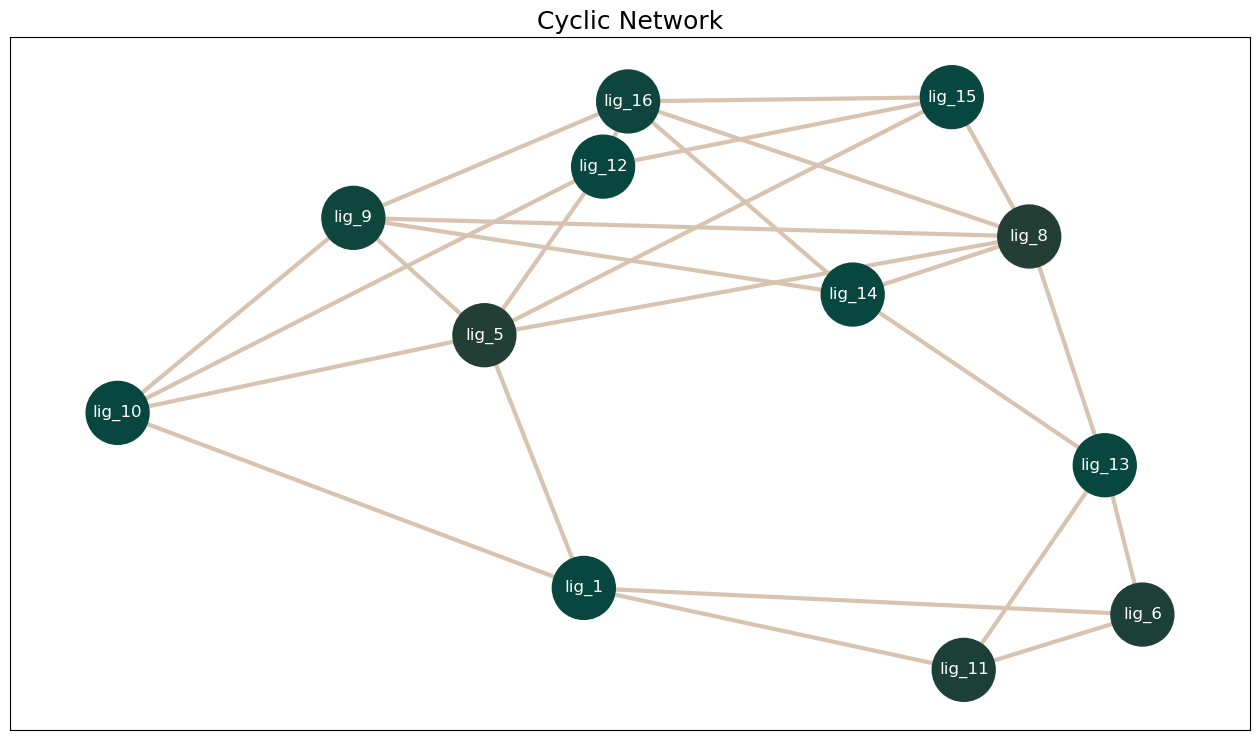

In [2]:
# Here we generate some import data.
from openfe_benchmarks import benzenes
compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"],
                        benzenes.get_system().ligand_components))

# Pick your Favourite Network layout with favourite AtomMapper and Scorer
from openfe.setup import KartografAtomMapper, lomap_scorers
from konnektor.network_planners import CyclicLigandNetworkPlanner
networker = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), 
                                       scorer=lomap_scorers.default_lomap_score)

# Generate Network
network =networker.generate_ligand_network(compounds)
network.name="Cyclic Network"

# Visualize the generated network
from konnektor.visualization import draw_ligand_network
fig = draw_ligand_network(network=network, title=network.name)

fig.show()

In [3]:
fig.savefig("example_out.png", dpi=300)